In [2]:
import pandas as pd
import numpy as np
import json
import math

In [8]:
# with open('/code/human-learning-strategies/responses/meditron-70b_medqa.json') as f:
#     data = json.load(f)
# df = pd.DataFrame(data['questions'])

# sum(df['correct_answer'] == df['response'])/len(df)

0.4046964040086461

In [3]:
def load_responses(filepath):
    with open(filepath) as f:
        data = json.load(f)

    df = pd.DataFrame(data["questions"])

    return df


def category_filter(df, category):
    subset = df[df["Category"] == category].copy()
    return subset


def correct_filter(df, incorrect=False):
    subset = df[(df["correct_answer"] == df["response"]) != incorrect].copy()
    return subset

In [4]:
def correct(df):
    df["correct"] = df["correct_answer"] == df["response"]
    return df["correct"].sum()


def accuracy(df):
    df["correct"] = df["correct_answer"] == df["response"]
    return df["correct"].sum() / len(df["correct"])


def expected_correct(df):
    df["expected_correct"] = df.apply(
        lambda x: math.exp(
            x["clls"][["A", "B", "C", "D", "E"].index(x["correct_answer"])]
        ),
        axis=1,
    )
    return df["expected_correct"].sum()


def expected_accuracy(df):
    df["expected_correct"] = df.apply(
        lambda x: math.exp(
            x["clls"][["A", "B", "C", "D", "E"].index(x["correct_answer"])]
        ),
        axis=1,
    )
    return df["expected_correct"].sum() / len(df)


def expected_correct_series(df):
    df["expected_correct"] = df.apply(
        lambda x: math.exp(
            x["clls"][["A", "B", "C", "D", "E"].index(x["correct_answer"])]
        ),
        axis=1,
    )
    return df["expected_correct"].values


def expected_accuracy_series(df):
    df["expected_correct"] = df.apply(
        lambda x: math.exp(
            x["clls"][["A", "B", "C", "D", "E"].index(x["correct_answer"])]
        ),
        axis=1,
    )
    return df["expected_correct"].values

In [5]:
def weight_dist(df):
    sorted_clls = pd.DataFrame(
        df["clls"].apply(lambda x: np.exp(np.array(sorted(x, reverse=True)))).tolist()
    )
    return (sorted_clls.sum() / len(df)).values

In [6]:
# dataset = 'medqa'
dataset = "LEK"

models = {
    "GPT 4 Turbo": "gpt-4-1106-preview",
    "GPT 3.5": "gpt-3.5-turbo-1106",
    "PaLM 2": "text-bison@002",
    "Mistral 8x7B": "Mixtral-8x7B-v0.1",
    "Meditron 70B": "meditron-70b",
    "Llama 2 70B": "Llama-2-70b-chat-hf",
}

models_df = pd.DataFrame.from_dict(models, columns=["hf_name"], orient="index")

models_df["filepath"] = "../responses/" + models_df["hf_name"] + "_" + dataset + ".json"

models_df["n_correct"] = models_df.apply(
    lambda x: correct(load_responses(x["filepath"])), axis=1
)
models_df["raw_accuracy"] = models_df.apply(
    lambda x: accuracy(load_responses(x["filepath"])), axis=1
)
models_df["expected_correct"] = models_df.apply(
    lambda x: expected_correct(load_responses(x["filepath"])), axis=1
)
models_df["expected_accuracy"] = models_df.apply(
    lambda x: expected_accuracy(load_responses(x["filepath"])), axis=1
)
models_df["expected_correct_series"] = models_df.apply(
    lambda x: expected_correct_series(load_responses(x["filepath"])), axis=1
)
models_df["expected_accuracy_series"] = models_df.apply(
    lambda x: expected_accuracy_series(load_responses(x["filepath"])), axis=1
)

<Axes: >

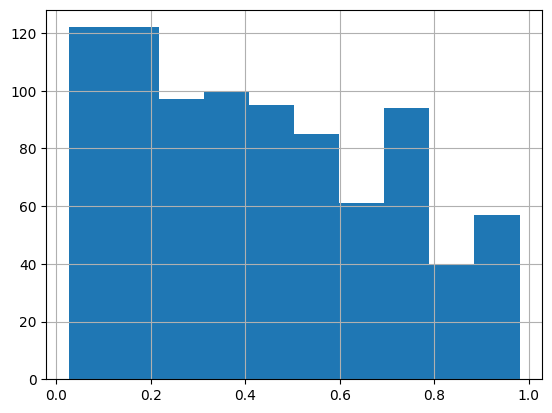

In [18]:
difficulty = 1 - models_df["expected_accuracy_series"].mean()
pd.Series(difficulty).hist()

### Compute the difficulty level per question as (1-expected accuracy)

In [7]:
# Assuming the models dictionary and dataset are defined
models = {
    "GPT 4 Turbo": "gpt-4-1106-preview",
    "GPT 3.5": "gpt-3.5-turbo-1106",
    "PaLM 2": "text-bison@002",
    "Mistral 8x7B": "Mixtral-8x7B-v0.1",
    "Meditron 70B": "meditron-70b",
    "Llama 2 70B": "Llama-2-70b-chat-hf",
}
dataset = "LEK"

# Load responses and compute expected_accuracy_series for each model
accuracy_data = {}
for model, hf_name in models.items():
    filepath = f"../responses/{hf_name}_{dataset}.json"
    df = load_responses(filepath)
    accuracy_data[model] = expected_accuracy_series(df)

# Convert the dictionary to a DataFrame where each column is a model and each row is a question
accuracy_df = pd.DataFrame(accuracy_data)

# Calculate mean expected accuracy across all models for each question
accuracy_df["mean_expected_accuracy"] = accuracy_df.mean(axis=1)

# Calculate the llm-scored difficulty for each question
accuracy_df["llm_difficulty"] = 1 - accuracy_df["mean_expected_accuracy"]

# Creating a DataFrame with the difficulty values
question_difficulty_df = accuracy_df[["llm_difficulty"]]

print(accuracy_df)

     GPT 4 Turbo   GPT 3.5    PaLM 2  Mistral 8x7B  Meditron 70B  Llama 2 70B  \
0       0.999087  0.006627  0.633000      0.378882      0.230191     0.674622   
1       0.002467  0.001343  0.015182      0.101399      0.262602     0.000000   
2       1.000000  0.779202  0.030978      0.188550      0.074491     0.000000   
3       0.988730  0.656007  0.846312      0.393976      0.681698     1.000000   
4       0.999195  0.096682  0.385622      0.206477      0.329814     0.697059   
..           ...       ...       ...           ...           ...          ...   
869     0.999957  0.999935  0.973756      0.588568      0.319145     1.000000   
870     1.000000  0.999908  0.979441      0.810557      0.495257     0.000000   
871     0.999820  0.997904  0.703434      0.663039      0.283005     0.000000   
872     1.000000  0.905703  0.818464      0.212269      0.142770     0.000000   
873     1.000000  0.999970  0.962265      0.886956      0.695855     0.826712   

     mean_expected_accuracy

In [8]:
# Resetting the index to add an index column
question_difficulty_df.reset_index(inplace=True)

# Rename the default 'index' column to 'Index'
question_difficulty_df.rename(columns={"index": "Index"}, inplace=True)

# Save the DataFrame to a CSV file
question_difficulty_df.to_csv(
    "/code/human-learning-strategies/measure_difficulty/llm_difficulty.csv", index=False
)

print("DataFrame with Index column is saved as 'llm_difficulty.csv'")

DataFrame with Index column is saved as 'llm_difficulty.csv'


/tmp/ipykernel_313285/66119465.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_difficulty_df.rename(columns={'index': 'Index'}, inplace=True)
